# **Connecting to Drive**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL2/[2023-2024] AN2DL/Personal

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL2/[2023-2024] AN2DL/Personal


# **Importing Libraries**

In [ ]:
# Fix randomness and hide warnings
seed = 42


from google.colab.patches import cv2_imshow

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import pandas as pd

import logging

import random
random.seed(seed)
import pickle

#TensorFlow Import
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

#from Vel
from tensorflow import nn
from tensorflow.nn import local_response_normalization

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries

import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

2.14.0


#**Loading and processing input data**


In [ ]:
# Conditional check for unzipping
unzip = False

# Unzip the 'animals.zip' file if the 'unzip' flag is True
if unzip:
    !unzip public_data.zip


In [ ]:
images = []
labels = []
data = np.load('public_data.npz', allow_pickle=True)
X_total = data['data']
Y_total = data['labels']

print(data['labels'][0])
#converting string labels into numerical values
for i in range(Y_total.shape[0]):
  if Y_total[i] == 'healthy':
     Y_total[i] = 0
  elif Y_total[i] == 'unhealthy':
     Y_total[i]= 1
  else:
     print('\nerror in labels data\n')
# Normalize image pixel values to a float range [0, 1]
X_total = X_total.astype("float32")/255.

print(pd.DataFrame(Y_total).value_counts())
print(pd.DataFrame(Y_total).describe())

Y_total = tfk.utils.to_categorical(Y_total)

X_train, X_val, y_train, y_val = train_test_split(X_total, Y_total, random_state=seed, test_size=0.1, stratify=Y_total)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



healthy
0    3199
1    2001
dtype: int64
           0
count   5200
unique     2
top        0
freq    3199
X_train shape: (4680, 96, 96, 3), y_train shape: (4680, 2)
X_val shape: (520, 96, 96, 3), y_val shape: (520, 2)


#**Building the model**

**Component building functions**

In [ ]:
#build the starting layers of the model after the input
def googlenet_start(input_layer):
  input_conv1 = tfkl.Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', name='input_conv1')(input_layer)
  relu1 = tfkl.ReLU(name='relu1')(input_conv1)

  input_pool1 = tfkl.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='input_mp1')(relu1)

  norm1 = nn.local_response_normalization(input=input_pool1)

  input_conv2 = tfkl.Conv2D(filters=192, kernel_size=(1,1), strides=(1,1), padding='same', name='input_conv2')(norm1)
  relu2 = tfkl.ReLU(name='relu2')(input_conv2)

  input_conv3 = tfkl.Conv2D(filters=192, kernel_size=(1,1), strides=(1,1), padding='same', name='input_conv3')(relu2)
  relu3 = tfkl.ReLU(name='relu3')(input_conv3)

  norm2 = nn.local_response_normalization(input=relu3)

  input_pool2 = tfkl.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='input_pool2')(norm2)

  return input_pool2



In [ ]:
# Define a inception block function with multiple parameters corresponding on the number of filters of each layer component
def inception_block(input_layer, conv1f, conv3Rf, conv3f, conv5Rf, conv5f, convPf, name=''):

    # Apply a stack of convolutional layers with specified filters, kernel size, and activation
    conv1_1x1 = tfkl.Conv2D(filters=conv1f, kernel_size=(1, 1), padding="same", name=name+'conv1_1x1')(input_layer)
    relu1x1 = tfkl.ReLU(name=name+'relu1x1')(conv1_1x1)

    conv3_1x1 = tfkl.Conv2D(filters=conv3Rf, kernel_size=(1, 1), padding="same", name=name+'conv2_1x1')(input_layer)
    relu3x3r = tfkl.ReLU(name=name+'relu3x3r')(conv3_1x1)

    conv5_1x1 = tfkl.Conv2D(filters=conv5Rf, kernel_size=(1, 1), padding="same", name=name+'conv3_1x1')(input_layer)
    relu5x5r = tfkl.ReLU(name=name+'relu5x5r')(conv5_1x1)
    max_pool = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding='same', name=name+'max_pool')(input_layer)

    conv3_3x3 = tfkl.Conv2D(filters=conv3f, kernel_size=(3, 3), padding="same", name=name+'conv3_3x3')(relu3x3r)
    relu3x3 = tfkl.ReLU(name=name+'relu3x3')(conv3_3x3)

    conv5_5x5 = tfkl.Conv2D(filters=conv5f, kernel_size=(5, 5), padding="same", name=name+'conv3_5x5')(relu5x5r)
    relu5x5 = tfkl.ReLU(name=name+'relu5x5')(conv5_5x5)

    convMax_1x1 = tfkl.Conv2D(filters=convPf, kernel_size=(1, 1), padding="same", name=name+'convMax_1x1')(max_pool)
    reluMax = tfkl.ReLU(name=name+'reluMax')(convMax_1x1)

    concatenation_output = tfkl.Concatenate(axis=-1)([relu1x1, relu3x3, relu5x5, reluMax])

    return concatenation_output

In [ ]:
#build an auxiliary classifier branching off the network
def build_auxiliary_classifier(input_layer, dropout_rate, output_shape, name):
  aux_avg_pool = tf.keras.layers.AveragePooling2D(pool_size=(5, 5), strides=(3,3))(input_layer)
  conv1_1x1 = tfkl.Conv2D(filters=128, kernel_size=(1, 1), padding="same", name=name+'aux_conv1_1x1')(aux_avg_pool)

  hidden_layer = tfkl.Dense(units=1024, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name=name+'HiddenDense1')(conv1_1x1)
  hidden_activation = tfkl.Activation('relu', name=name+'HiddenActivation1')(hidden_layer)
  dropout = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

  x = tfkl.Flatten()(dropout)

  output_activation = tfkl.Dense(units=output_shape, activation='softmax',name=name+'classifier')(x)

  return output_activation

In [ ]:
#build layers dedicated to apply random transformations to the images in order to augment the resilience of the network to new data
def image_preprocessing():
    preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),
        tfkl.RandomContrast(0.2)
    ], name='preprocessing')
    return preprocessing


**GoogLeNet model assembling**

Model: "tempnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 preprocessing (Sequential)  (None, 96, 96, 3)            0         ['Input[0][0]']               
                                                                                                  
 input_conv1 (Conv2D)        (None, 48, 48, 64)           9472      ['preprocessing[0][0]']       
                                                                                                  
 relu1 (ReLU)                (None, 48, 48, 64)           0         ['input_conv1[0][0]']         
                                                                                            

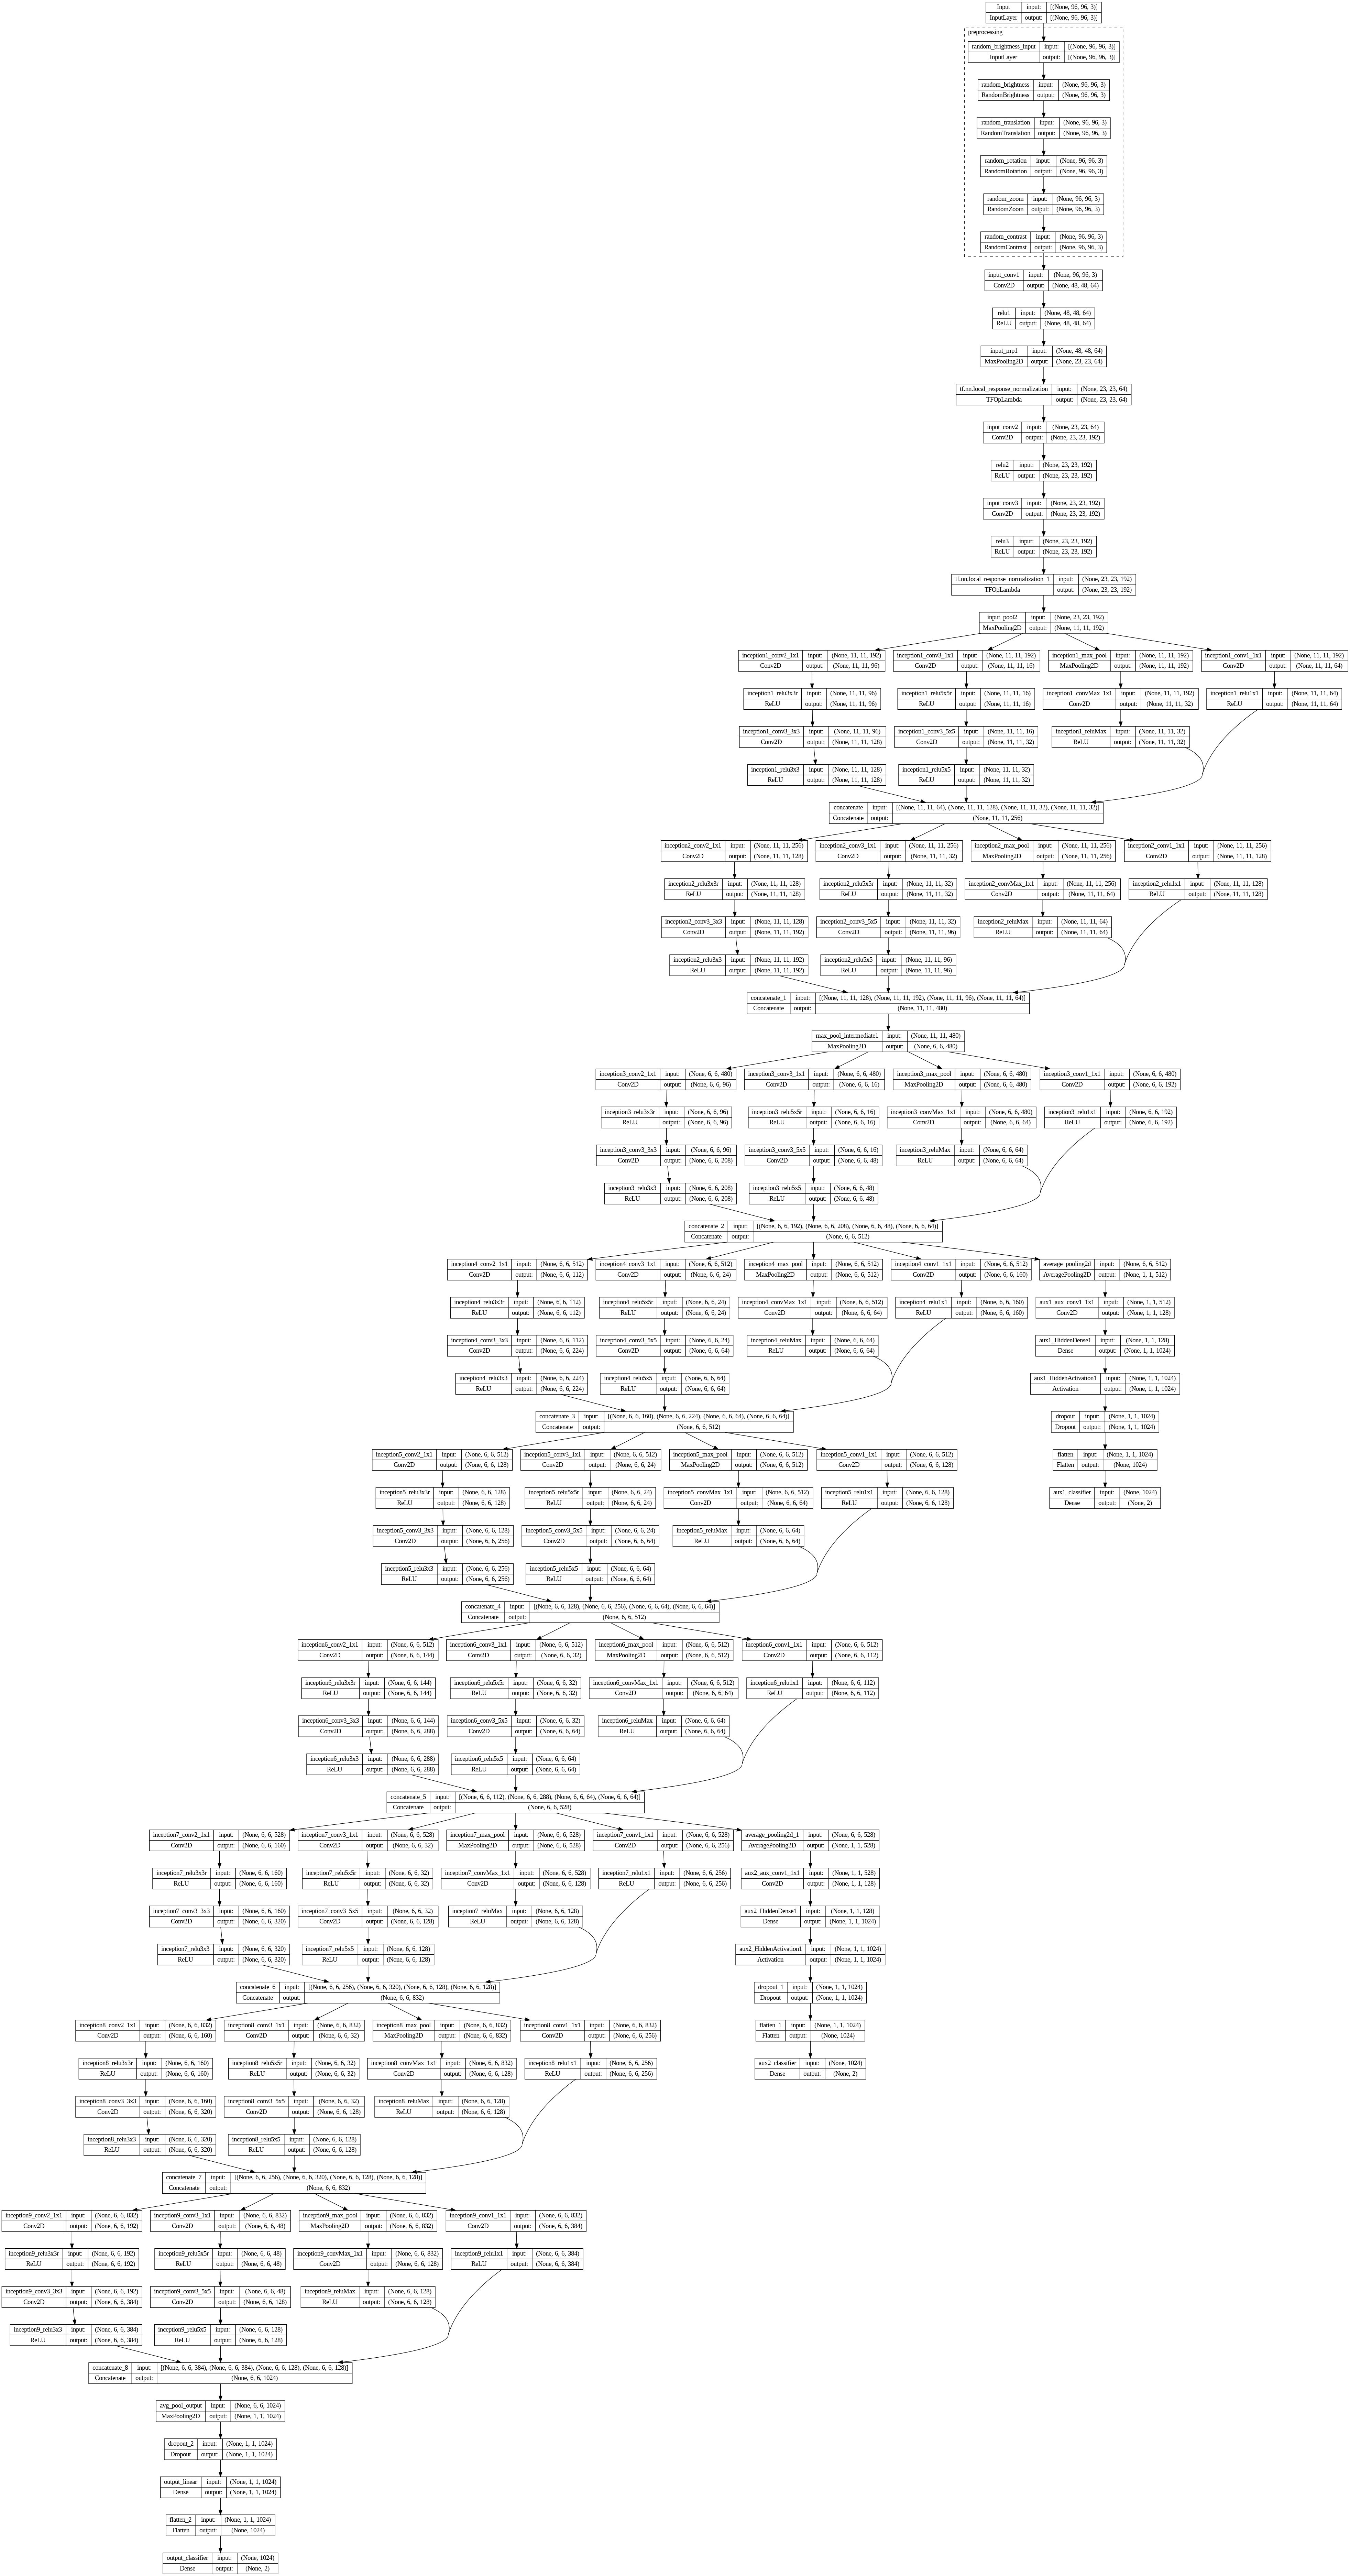

In [ ]:
#Input and preprocessing section
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

preprocessing_layer = image_preprocessing()
input_layer = tfkl.Input(shape=input_shape, name='Input')
preprocessing_layer = preprocessing_layer(input_layer)

#start of the model
input_block_output = googlenet_start(input_layer=preprocessing_layer)

#main body (inception blocks and auxiliary classifiers)
inception1 = inception_block(input_layer=input_block_output, conv1f=64, conv3Rf=96, conv3f=128, conv5Rf=16, conv5f=32, convPf=32, name='inception1_')
inception2 = inception_block(input_layer=inception1, conv1f=128, conv3Rf=128, conv3f=192, conv5Rf=32, conv5f=96, convPf=64, name='inception2_')
max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same', name='max_pool_intermediate1')(inception2)
inception3 = inception_block(input_layer=max_pool1, conv1f=192, conv3Rf=96, conv3f=208, conv5Rf=16, conv5f=48, convPf=64, name='inception3_')

aux_classifier1 = build_auxiliary_classifier(input_layer=inception3, output_shape=output_shape, dropout_rate=7/10, name='aux1_')

inception4 = inception_block(input_layer=inception3, conv1f=160, conv3Rf=112, conv3f=224, conv5Rf=24, conv5f=64, convPf=64, name='inception4_')
inception5 = inception_block(input_layer=inception4, conv1f=128, conv3Rf=128, conv3f=256, conv5Rf=24, conv5f=64, convPf=64, name='inception5_')
inception6 = inception_block(input_layer=inception5, conv1f=112, conv3Rf=144, conv3f=288, conv5Rf=32, conv5f=64, convPf=64, name='inception6_')

aux_classifier2 = build_auxiliary_classifier(input_layer=inception6, output_shape=output_shape, dropout_rate=7/10, name='aux2_')

inception7 = inception_block(input_layer=inception6, conv1f=256, conv3Rf=160, conv3f=320, conv5Rf=32, conv5f=128, convPf=128, name='inception7_')

max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same', name='max_pool_intermediate2')(inception7)

inception8 = inception_block(input_layer=inception7, conv1f=256, conv3Rf=160, conv3f=320, conv5Rf=32, conv5f=128, convPf=128, name='inception8_')
inception9 = inception_block(input_layer=inception8, conv1f=384, conv3Rf=192, conv3f=384, conv5Rf=48, conv5f=128, convPf=128, name='inception9_')

#final section, output
avg_pool_output = tf.keras.layers.MaxPooling2D(pool_size=(6, 6), strides=(1,1), padding='valid', name='avg_pool_output')(inception9)
dropout = tfkl.Dropout(rate=4/10, seed=seed)(avg_pool_output)
fully_connected_output = tfkl.Dense(units=1024, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='output_linear')(dropout)
x = tfkl.Flatten()(fully_connected_output)

output_activation = tfkl.Dense(units=output_shape, activation='softmax',name='output_classifier')(x)

model = tfk.Model(inputs=input_layer, outputs=[output_activation, aux_classifier1, aux_classifier2], name='tempnet')

# Compiling the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Creating EarlyStopping and Dynamic learning rate callbacks
patience = 6
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='output_classifier_accuracy',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

lr_patience = 3
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='output_classifier_accuracy',
    patience=lr_patience,
    factor=0.7,
    mode='min',
    min_lr=1e-7
)

callbacks = [early_stopping, lr_scheduler]


batch_size=64
epochs=50

# Training the model and saving its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Saving the model
model.save('GooglenetSTD')

Epoch 1/50
74/74 [==============================] - 323s 4s/step - loss: 2.0005 - output_classifier_loss: 0.6681 - aux1_classifier_loss: 0.6652 - aux2_classifier_loss: 0.6672 - output_classifier_accuracy: 0.6120 - aux1_classifier_accuracy: 0.6113 - aux2_classifier_accuracy: 0.6113 - val_loss: 1.9847 - val_output_classifier_loss: 0.6632 - val_aux1_classifier_loss: 0.6604 - val_aux2_classifier_loss: 0.6610 - val_output_classifier_accuracy: 0.6154 - val_aux1_classifier_accuracy: 0.6154 - val_aux2_classifier_accuracy: 0.6154 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - 293s 4s/step - loss: 1.9757 - output_classifier_loss: 0.6581 - aux1_classifier_loss: 0.6590 - aux2_classifier_loss: 0.6586 - output_classifier_accuracy: 0.6152 - aux1_classifier_accuracy: 0.6152 - aux2_classifier_accuracy: 0.6152 - val_loss: 1.9852 - val_output_classifier_loss: 0.6612 - val_aux1_classifier_loss: 0.6631 - val_aux2_classifier_loss: 0.6609 - val_output_classifier_accuracy: 0.6154 - val_aux1_

#**Plotting training data**

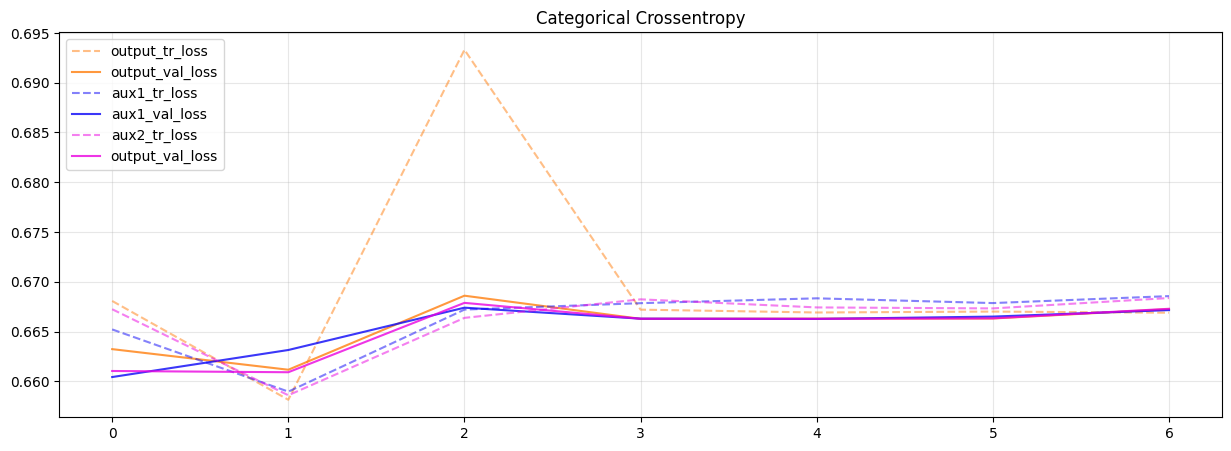

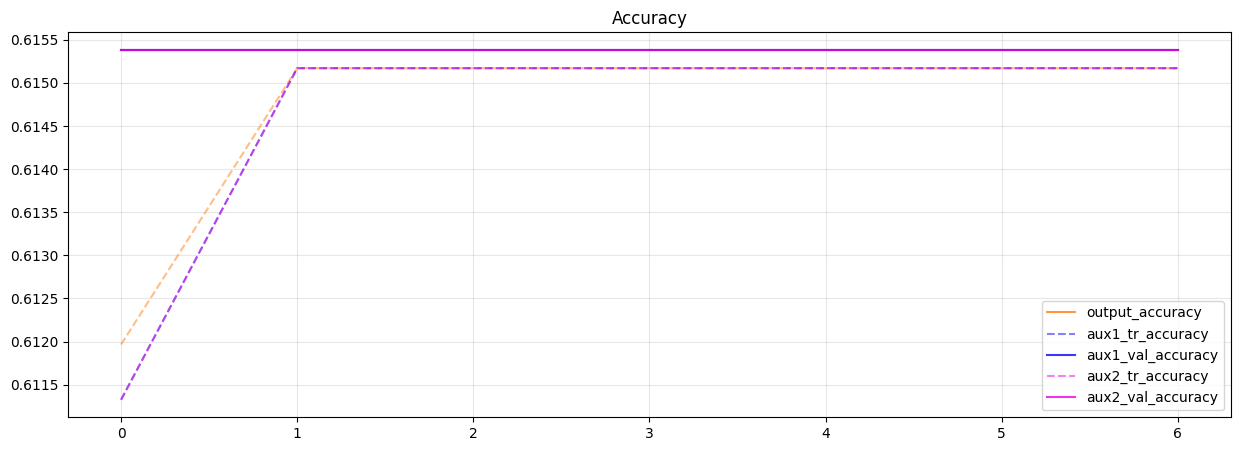

In [ ]:
# Plot the training and validation data for each output
plt.figure(figsize=(15,5))
plt.plot(history['output_classifier_loss'], label='output_tr_loss' ,alpha=.5, color='#ff7f0e', linestyle='--')
plt.plot(history['val_output_classifier_loss'], label='output_val_loss', alpha=.8, color='#ff7f0e')

plt.plot(history['aux1_classifier_loss'], label='aux1_tr_loss' ,alpha=.5, color='#0a05f7', linestyle='--')
plt.plot(history['val_aux1_classifier_loss'], label='aux1_val_loss', alpha=.8, color='#0a05f7')

plt.plot(history['aux2_classifier_loss'], label='aux2_tr_loss' ,alpha=.5, color='#ea02e0', linestyle='--')
plt.plot(history['val_aux2_classifier_loss'], label='output_val_loss', alpha=.8, color='#ea02e0')

plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)


plt.figure(figsize=(15,5))
plt.plot(history['output_classifier_accuracy'], alpha=.5, color='#ff7f0e', linestyle='--')
plt.plot(history['val_output_classifier_accuracy'], label='output_accuracy', alpha=.8, color='#ff7f0e')

plt.plot(history['aux1_classifier_accuracy'], label='aux1_tr_accuracy' ,alpha=.5, color='#0a05f7', linestyle='--')
plt.plot(history['val_aux1_classifier_accuracy'], label='aux1_val_accuracy', alpha=.8, color='#0a05f7')

plt.plot(history['aux2_classifier_accuracy'], label='aux2_tr_accuracy' ,alpha=.5, color='#ea02e0', linestyle='--')
plt.plot(history['val_aux2_classifier_accuracy'], label='aux2_val_accuracy', alpha=.8, color='#ea02e0')


plt.legend(loc='lower right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()